In [ ]:
import cv2 # Library for dealing with images, the biggest and the fastest, written in cpp, wrapped in python.
import os # Library for dealing wiht the operating system, getting folders, files, and much much more.
import numpy as np # Numerical Python, library for doing most of the mathematical operations needed in machine learning.
import torch
from torchvision import transforms
import torchvision.models as models
import torch.nn as nn

resnet = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)
resnet_no_output = nn.Sequential(*list(resnet.children())[:-1])

def extract_features(data_dir, model):

    model.eval()
    
    features = []
    labels = []

    classes_names = [entry.name for entry in os.scandir(data_dir) if entry.is_dir()]
    classes_names = sorted(classes_names)

    
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]) # preprocess is a function preprocesses the data

    for class_index, class_name in enumerate(classes_names):
        class_path = os.path.join(data_dir,class_name)
        print(f"Loading Class {class_index}: {class_name}")


        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            
            try:
                img_np_arr = cv2.imread(img_path)

                if img_np_arr is None:
                    continue

                img_rgb = cv2.cvtColor(img_np_arr, cv2.COLOR_BGR2RGB)
                img_t = preprocess(img_rgb) # resize, convert to tensor and normalize
                input_batch = img_t.unsqueeze(0) # checks if there is batch size if not adds index for the bathc size at the begining

                # doesn't learn
                with torch.no_grad():
                    output_tensor = model(input_batch)
                    feature_vector = output_tensor.flatten().cpu().numpy()
                
                features.append(feature_vector)
                labels.append(class_index)

            except Exception as e:
                print(f"Error loading {img_name}: {e}")

    return np.array(features), np.array(labels), classes_names
    

# Splitting the data

In [ ]:
from sklearn.model_selection import train_test_split
features, labels, classes_names = extract_features(r"C:\Life\FCAI_Stuff\Third_year_AI\Intro_to_ML\Assignments\Sea_Animals",resnet_no_output)
# Psudsfnjfnsdlfjsjkjfo random تقليفه
# split to (train + validate) and (test)
x_train_validate, x_test, y_train_validate, y_test = train_test_split(
    features,
    labels,
    test_size = 0.15,
    stratify = labels,
    random_state = 42
) 
# split x/y(train_validate) into train and validate
x_train, x_validate, y_train, y_validate = train_test_split(
    x_train_validate,
    y_train_validate,
    test_size = 0.15,
    stratify = y_train_validate,
    random_state = 42
)

Loading Class 0: Clams
Loading Class 1: Corals
Loading Class 2: Crabs
Loading Class 3: Dolphin
Loading Class 4: Eel
Loading Class 5: Fish
Loading Class 6: Jelly_Fish
Loading Class 7: Lobster
Loading Class 8: Nudibranchs
Loading Class 9: Octopus
Loading Class 10: Otter
Loading Class 11: Penguin
Loading Class 12: Puffers
Loading Class 13: Sea_Rays
Loading Class 14: Sea_Urchins
Loading Class 15: Seahorse
Loading Class 16: Seal
Loading Class 17: Sharks
Loading Class 18: Shrimp
Loading Class 19: Squid
Loading Class 20: Starfish
Loading Class 21: Turtle_Tortoise
Loading Class 22: Whale


# Marine Model definition

In [ ]:
class MarineModel(nn.Module):
    def __init__(self, input_size, layers_sizes, output_size, func):
        super(MarineModel, self).__init__()

        layers = []
        current_dim = input_size
        activ_funcs = {'relu': nn.ReLU(), 'sigmoid': nn.Sigmoid(), 'tanh': nn.Tanh()}

        for hidden_dim in layers_sizes:
            # Connect current layer with next hidden layer
            layers.append(nn.Linear(current_dim, hidden_dim))
    
            layers.append(activ_funcs[func])

            current_dim = hidden_dim
        # Add the final output layer
        layers.append(nn.Linear(current_dim, output_size))
        # Pack the list into the Sequential container
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

In [29]:
input_features = 512
hidden_neurons = 128
num_classes = 23

model = MarineModel(input_features, hidden_neurons, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)

MarineModel(
  (layer1): Linear(in_features=512, out_features=128, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=128, out_features=23, bias=True)
)


# Optimization

In [52]:
import torch.optim as optim

learning_rate = 0.001
num_epochs = 20
batch_size = 32

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# The Training Loop

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# 1.Prepeare DataLoaders
# Convert numpy arrays to PyTorch tesnsors
train_data = TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).long())
validate_data = TensorDataset(torch.tensor(x_validate).float(), torch.tensor(y_validate).long())

train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
validation_loader = DataLoader(validate_data, batch_size = batch_size, shuffle = False)

train_loss_hist = []
validation_loss_hist = []
train_acc_hist = []
validation_acc_hist = []

print(f"Training on {device}...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Track Training Accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    model.eval()
    validation_loss = 0.0
    validation_correct = 0
    validation_total = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs,labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            validation_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            validation_total += labels.size(0)
            validation_correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    avg_validation_loss = validation_loss / len(validation_loader)
    
    current_train_acc = 100 * train_correct / train_total
    current_validation_acc = 100 * validation_correct / validation_total

    train_loss_hist.append(avg_train_loss)
    validation_loss_hist.append(avg_validation_loss)
    train_acc_hist.append(current_train_acc)
    validation_acc_hist.append(current_validation_acc)

    print(f"Epoch [{epoch + 1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_validation_loss:.4f} | "
          f"Train Acc: {current_train_acc:.2f}% | Val Acc: {current_validation_acc:.2f}%")
    
print("Training Complete!")


Training on cuda...
Epoch [1/20] | Train Loss: 0.0198 | Val Loss: 3.0331 | Train Acc: 99.40% | Val Acc: 74.04%
Epoch [2/20] | Train Loss: 0.0204 | Val Loss: 2.8700 | Train Acc: 99.33% | Val Acc: 75.41%
Epoch [3/20] | Train Loss: 0.0261 | Val Loss: 3.0156 | Train Acc: 99.25% | Val Acc: 74.61%
Epoch [4/20] | Train Loss: 0.0281 | Val Loss: 3.0481 | Train Acc: 99.12% | Val Acc: 74.90%
Epoch [5/20] | Train Loss: 0.0225 | Val Loss: 2.8955 | Train Acc: 99.37% | Val Acc: 74.73%
Epoch [6/20] | Train Loss: 0.0190 | Val Loss: 2.8840 | Train Acc: 99.41% | Val Acc: 75.53%
Epoch [7/20] | Train Loss: 0.0204 | Val Loss: 2.9157 | Train Acc: 99.36% | Val Acc: 74.39%
Epoch [8/20] | Train Loss: 0.0229 | Val Loss: 2.9105 | Train Acc: 99.32% | Val Acc: 75.70%
Epoch [9/20] | Train Loss: 0.0235 | Val Loss: 2.9632 | Train Acc: 99.32% | Val Acc: 74.61%
Epoch [10/20] | Train Loss: 0.0354 | Val Loss: 2.8493 | Train Acc: 98.88% | Val Acc: 74.56%
Epoch [11/20] | Train Loss: 0.0206 | Val Loss: 2.9127 | Train Acc: 99

In [64]:
def predict_pytorch_model(model, test_feature, classes_names):
    """
    Takes a single test feature (numpy array or tensor),
    predicts the class, and prints the result.
    """
    model.eval()

    # Prepare the input
    if isinstance(test_feature, np.ndarray):
        test_feature = torch.from_numpy(test_feature).float()

    # Add batch dimension if it's missing (size 512 -> 1x512)
    if len(test_feature.shape) == 1:
        test_feature = test_feature.unsqueeze(0)

    test_feature = test_feature.to(device)

    with torch.no_grad():
        output = model(test_feature)

        _, predicted_idx = torch.max(output, 1)
        predicted_class = classes_names[predicted_idx.item()]

    print(f"Predicted Class: {predicted_class}")
    return predicted_class

import random
random_idx = random.randint(0, len(x_test) - 1)
print(f"True Class: {classes_names[y_test[random_idx]]}")
predict_pytorch_model(model, x_test[random_idx], classes_names)

True Class: Whale
Predicted Class: Whale


'Whale'

In [ ]:
# import cv2
# import torch
# from torchvision import transforms

# def predict_image_path(img_path, feature_extractor, classifier, classes_names, device):
#     classifier.eval()
#     # same preprocessing as training
#     preprocess = transforms.Compose([
#         transforms.ToPILImage(),
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ])

#     # load image with cv2 (BGR) → RGB
#     img_np = cv2.imread(img_path)
#     if img_np is None:
#         raise ValueError(f"Could not read image: {img_path}")
#     img_rgb = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)

#     # preprocess
#     img_t = preprocess(img_rgb)              # shape: (3,224,224)
#     input_batch = img_t.unsqueeze(0).to(device)

#     # extract features with resnet backbone
#     feature_extractor.eval()
#     with torch.no_grad():
#         feats = feature_extractor(input_batch)  # shape: (1, 512, 1, 1)
#     feats_flat = feats.view(feats.size(0), -1).cpu().numpy().squeeze(0)  # shape: (512,)

#     # classify with your MLP
#     return predict_pytorch_model(classifier, feats_flat, classes_names)

# # Example usage
# test_path = r"C:\Life\Important_Files\Ayman.jpg"
# predict_image_path(test_path, resnet_no_output.to(device), model, classes_names, device)

# # Mohamed with beard -> Turtle_Torotise
# # Mohamed without beard -> Seahorse

# # Ali Military -> Turtule_Torotise
# # Ali Normal -> Seahorse

# # Very Good People -> Jelly_Fish

# # Ayman -> Turtle_Tortise


Predicted Class: Turtle_Tortoise


'Turtle_Tortoise'

In [89]:
import matplotlib.pyplot as plt

def plot_results(train_loss, validation_loss, train_acc, validation_acc):

    # Move tesnors to CPU if they are on GPU, and convert to numpy/list
    # This hadndles cases where data might still be tensors
    if isinstance(train_loss[0], torch.Tensor):
        train_loss = [x.cpu().item() for x in train_loss]
        validation_loss = [x.cpu().item() for x in validation_loss]
        train_acc = [x for x in train_acc]
        validation_acc = [x for x in validation_acc]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

    ax1.plot(train_loss, label = "Training Loss", color = 'blue')
    ax1.plot(validation_loss, label = "Validation Loss", color = 'red', linestyle = '--')
    ax1.set_title("Loss History")
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Epochs")
    ax1.legend()
    ax1.grid(True, alpha = 0.3)

    ax2.plot(train_acc, label = "Training Accuracy", color = 'blue')
    ax2.plot(validation_acc, label = "Validation Accuracy", color = 'red', linestyle = '--')
    ax2.set_title("Accuarcy History")
    ax2.set_ylabel("Accuracy (%)")
    ax2.set_xlabel("Epochs")
    ax2.legend()
    ax2.grid(True, alpha = 0.3)

    plt.tight_layout()
    plt.show()

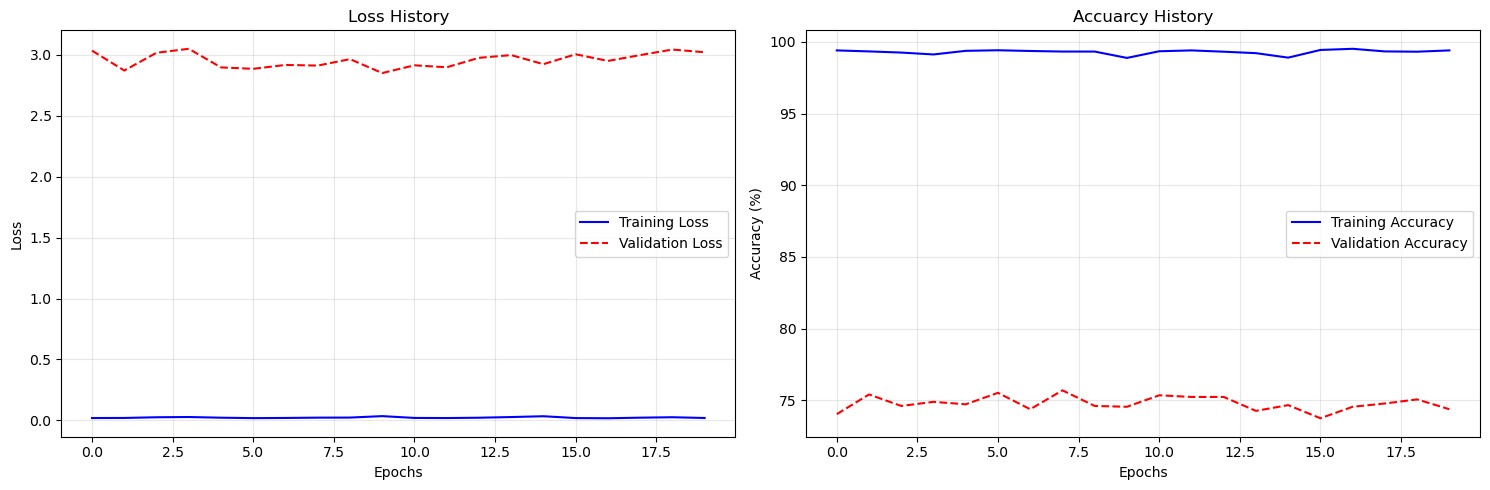

In [90]:
plot_results(train_loss_hist, validation_loss_hist, train_acc_hist, validation_acc_hist)

# Optimizing function